## Smooth curve comparison

Overall Mean Brightness: 91.00
Overall Mode Brightness: 89.00


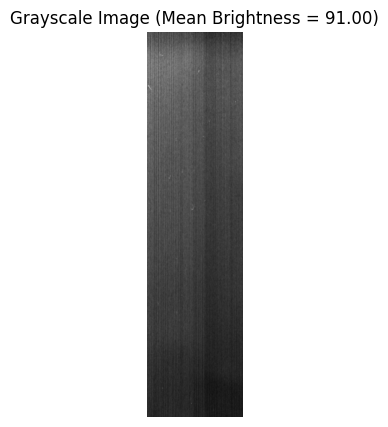

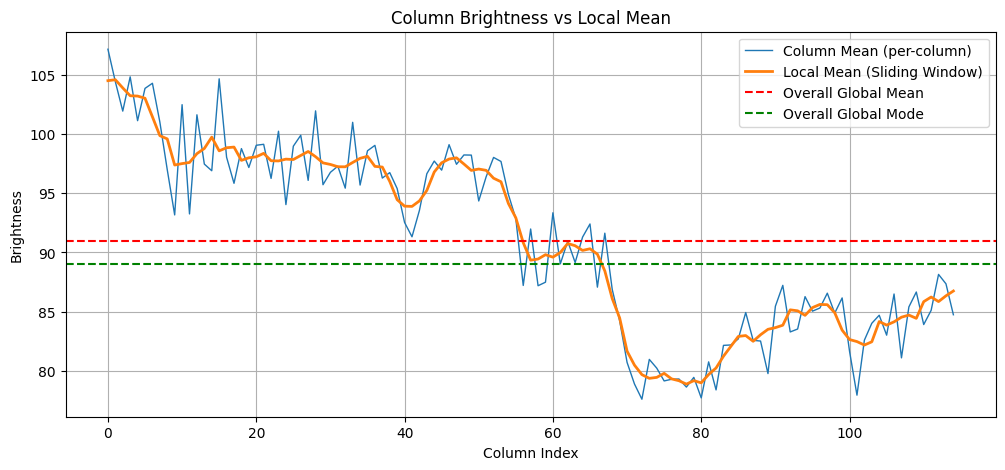


=== Mean-based Defect Region Summary ===
V1: 2 defect region(s)
V2: 1 defect region(s)
V3: 0 defect region(s)

=== MODE-based Defect Region Summary ===
V1: 1 defect region(s)
V2: 2 defect region(s)
V3: 1 defect region(s)




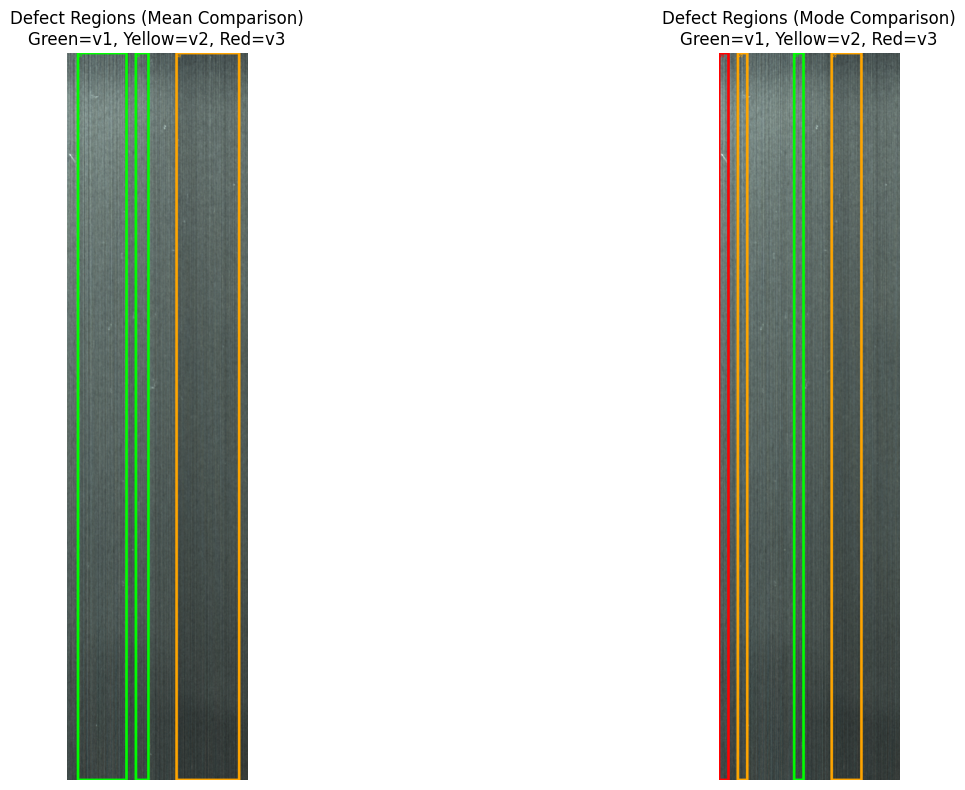

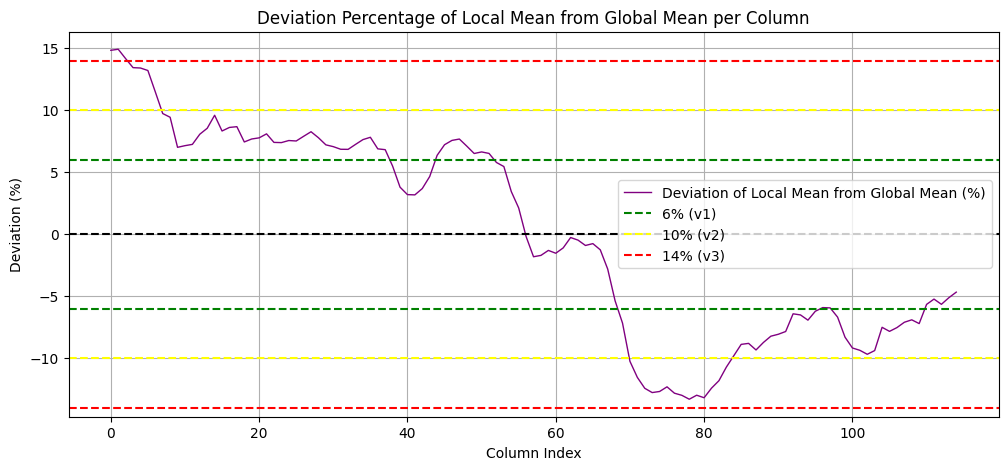

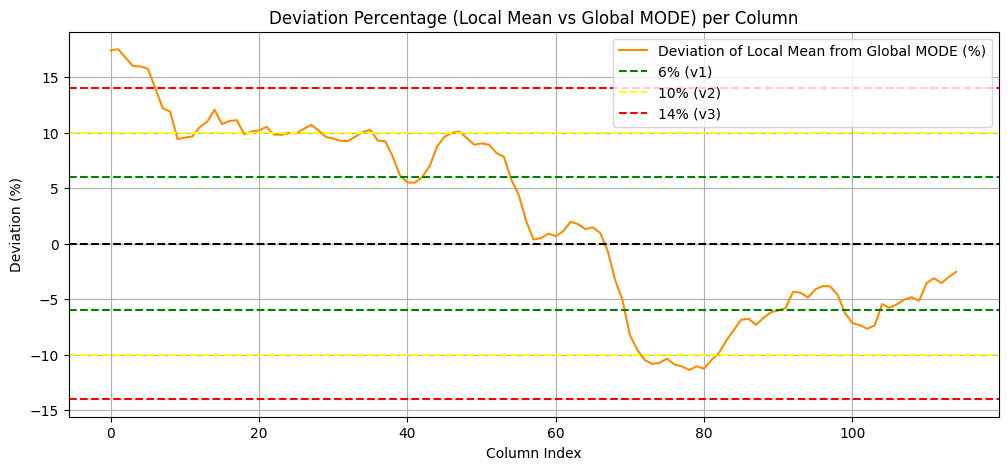

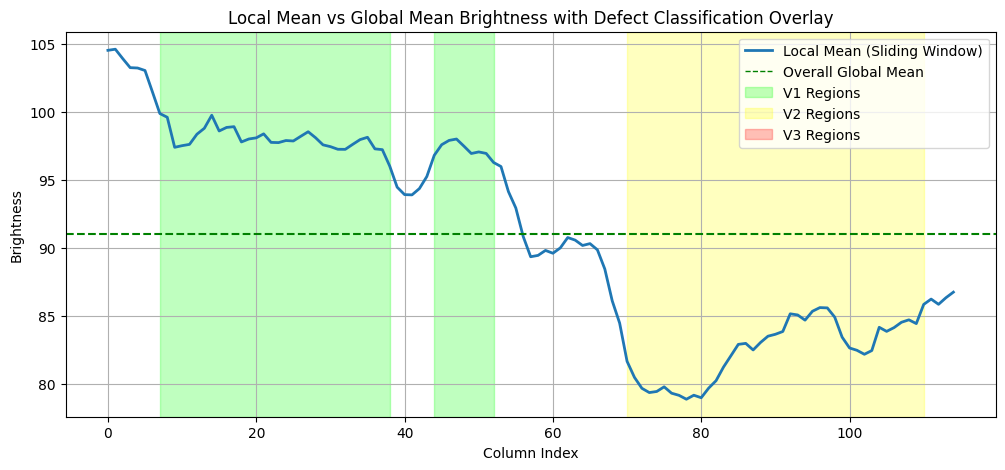

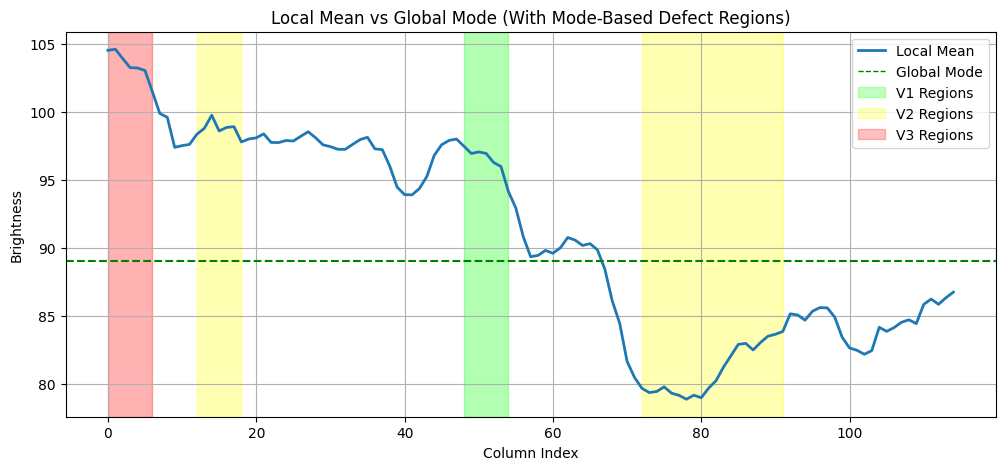

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter

# --- Load and preprocess image ---
img_path = r"Evenness/Testing/3.png"   
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = gray.shape

# --- Adjustable column width ---
column_width = 10  # Increase this to widen each column before computing mean

# --- Recalculate number of columns based on width ---
num_cols = w // column_width #1100/10=110 column, where each strip is 11cm(i.e., 10 columns = 1mm)
if num_cols <= 0:
    raise ValueError("Column width too large for image width.")

# --- Compute column-wise mean brightness with wider columns ---
column_means = []
for i in range(num_cols):
    start = i * column_width
    end = min((i + 1) * column_width, w)
    block = gray[:, start:end]
    col_mean = np.mean(block)
    column_means.append(col_mean)
column_means = np.array(column_means)

# --- Compute overall mean and mode brightness ---
mean_brightness = float(np.mean(gray))
# compute mode from whole image (flatten)
mode_res = stats.mode(gray.flatten(), keepdims=True)
mode_brightness = float(mode_res.mode[0]) if mode_res.count.size > 0 else 0.0

print(f"Overall Mean Brightness: {mean_brightness:.2f}")
print(f"Overall Mode Brightness: {mode_brightness:.2f}")

# --- Sliding window local statistics (local mean & std per column) ---
window_size = 5  # number of neighboring columns for local stats (odd recommended)
half_w = window_size // 2

local_means = []
local_stds = []
for i in range(num_cols):
    start = max(0, i - half_w)
    end = min(num_cols, i + half_w + 1)
    local_region = column_means[start:end]
    local_means.append(np.mean(local_region))
    local_stds.append(np.std(local_region))
local_means = np.array(local_means)
local_stds = np.array(local_stds)

# --- Compute deviation percentage using Local Mean vs Global Mean (per your request) ---
eps = 1e-8
deviation_percent = ((local_means - mean_brightness) / (mean_brightness + eps)) * 100

# --- Classification thresholds ---
v1_threshold = 6
v2_threshold = 10
v3_threshold = 14

colors = {
    'v1': (0, 255, 0),       # Bright Green
    'v2': (0, 165, 255),     # Bright Orange
    'v3': (0, 0, 255)        # Bright Red
}


priority = {'v1': 1, 'v2': 2, 'v3': 3}
mpl_colors = {'v1': (0, 1, 0, 0.25), 'v2': (1, 1, 0, 0.25), 'v3': (1, 0, 0, 0.25)}  # RGBA for plotting regions

# --- Classify columns based on deviation_percent ---
def classify(dev):
    abs_dev = abs(dev)
    if abs_dev >= v3_threshold:
        return 'v3'
    elif abs_dev >= v2_threshold:
        return 'v2'
    elif abs_dev >= v1_threshold:
        return 'v1'
    else:
        return None

column_classes = [classify(dev) for dev in deviation_percent]

# --- Merge adjacent columns of the same class into regions ---
regions = []
start = None
current_class = None

for i in range(num_cols):
    c = column_classes[i]
    if c != current_class:
        if current_class is not None:
            regions.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
# close the last region
if current_class is not None:
    regions.append((start, num_cols - 1, current_class))

# --- Apply minimum region length condition (number of consecutive columns) ---
min_cols_for_defect = 6   # keep >=10 consecutive columns (matches printed message)
filtered_regions = [
    (start, end, cls)
    for start, end, cls in regions
    if (end - start + 1) >= min_cols_for_defect
]

# --- Resolve overlapping boxes: keep only highest-priority class ---
final_classes = [None] * num_cols
for start, end, cls in filtered_regions:
    for i in range(start, end + 1):
        if final_classes[i] is None or priority[cls] > priority.get(final_classes[i], 0):
            final_classes[i] = cls

# --- Rebuild final regions after overlap resolution ---
final_regions = []
start = None
current_class = None
for i in range(num_cols):
    c = final_classes[i]
    if c != current_class:
        if current_class is not None:
            final_regions.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
if current_class is not None:
    final_regions.append((start, num_cols - 1, current_class))

#merge adjacent bounding box if their distance is less than min_cols_for_defect
merged_regions = []
i = 0

while i < len(final_regions):
    start1, end1, cls1 = final_regions[i]
    width1 = end1 - start1 + 1

    # Look ahead for merging candidate
    j = i + 1
    while j < len(final_regions):
        start2, end2, cls2 = final_regions[j]
        width2 = end2 - start2 + 1

        # distance between current region and next region
        gap = start2 - end1 - 1

        if gap < min_cols_for_defect:
            # Decide which class to keep (choose region with larger width)
            chosen_class = cls1 if width1 >= width2 else cls2

            # Merge the two regions
            end1 = end2
            cls1 = chosen_class
            width1 = end1 - start1 + 1  # update width

            j += 1
        else:
            break

    merged_regions.append((start1, end1, cls1))
    i = j

# Replace old final_regions
final_regions = merged_regions

# --- Draw final bounding boxes on a copy of the original image ---
output_img = img.copy()
class_counts = {'v1': 0, 'v2': 0, 'v3': 0}

for start, end, cls in final_regions:
    color = colors[cls]
    x1 = start * column_width
    x2 = min((end + 1) * column_width, w - 1)
    cv2.rectangle(output_img, (x1, 0), (x2, h - 1), color, 15)
    class_counts[cls] += 1
    cv2.putText(output_img, cls.upper(), (x1 + 5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# --- Plot 1: Grayscale image ---
plt.figure(figsize=(10, 5))
plt.imshow(gray, cmap='gray')
plt.title(f"Grayscale Image (Mean Brightness = {mean_brightness:.2f})")
plt.axis("off")
plt.show()

# --- Plot 2: Column brightness with Local Mean and Global Mean ---
plt.figure(figsize=(12, 5))
plt.plot(column_means, label='Column Mean (per-column)', linewidth=1)
plt.plot(local_means, label='Local Mean (Sliding Window)', linewidth=2)
plt.axhline(y=mean_brightness, color='red', linestyle='--', label='Overall Global Mean')
plt.axhline(y=mode_brightness, color='green', linestyle='--', label='Overall Global Mode')
plt.title("Column Brightness vs Local Mean")
plt.xlabel("Column Index")
plt.ylabel("Brightness")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
#      PIPELINE → USING GLOBAL MODE AS COMPARATOR
# ============================================================

# --- Compute deviation percentage using Local Mean vs Global MODE ---
deviation_percent_mode = ((local_means - mode_brightness) / (mode_brightness + eps)) * 100

# --- Classify columns based on deviation from MODE ---
column_classes_mode = [classify(dev) for dev in deviation_percent_mode]

# --- Merge adjacent columns of same class ---
regions_mode = []
start = None
current_class = None
for i in range(num_cols):
    c = column_classes_mode[i]
    if c != current_class:
        if current_class is not None:
            regions_mode.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
if current_class is not None:
    regions_mode.append((start, num_cols - 1, current_class))

# --- Apply minimum consecutive column rule ---
filtered_regions_mode = [
    (start, end, cls)
    for start, end, cls in regions_mode
    if (end - start + 1) >= min_cols_for_defect
]

# --- Resolve overlap using priority ---
final_classes_mode = [None] * num_cols
for start, end, cls in filtered_regions_mode:
    for i in range(start, end + 1):
        if final_classes_mode[i] is None or priority[cls] > priority.get(final_classes_mode[i], 0):
            final_classes_mode[i] = cls

# --- Rebuild merged regions ---
final_regions_mode = []
start = None
current_class = None
for i in range(num_cols):
    c = final_classes_mode[i]
    if c != current_class:
        if current_class is not None:
            final_regions_mode.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
if current_class is not None:
    final_regions_mode.append((start, num_cols - 1, current_class))

merged_regions_mode = []
i = 0

while i < len(final_regions_mode):
    start1, end1, cls1 = final_regions_mode[i]
    width1 = end1 - start1 + 1

    j = i + 1
    while j < len(final_regions_mode):
        start2, end2, cls2 = final_regions_mode[j]
        width2 = end2 - start2 + 1

        gap = start2 - end1 - 1

        if gap < min_cols_for_defect:
            chosen_class = cls1 if width1 >= width2 else cls2
            end1 = end2
            cls1 = chosen_class
            width1 = end1 - start1 + 1
            j += 1
        else:
            break

    merged_regions_mode.append((start1, end1, cls1))
    i = j

final_regions_mode = merged_regions_mode

# --- Draw bounding boxes for MODE-based detection ---
output_img_mode = img.copy()
class_counts_mode = {'v1': 0, 'v2': 0, 'v3': 0}

for start, end, cls in final_regions_mode:
    color = colors[cls]
    x1 = start * column_width
    x2 = min((end + 1) * column_width, w - 1)
    cv2.rectangle(output_img_mode, (x1, 0), (x2, h - 1), color, 15)
    class_counts_mode[cls] += 1
    cv2.putText(output_img_mode, cls.upper(), (x1 + 5, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# --- Print defect statistics ---
print("\n=== Mean-based Defect Region Summary ===")
for cls, count in class_counts.items():
    print(f"{cls.upper()}: {count} defect region(s)")

# --- Print statistics ---
print("\n=== MODE-based Defect Region Summary ===")
for cls, count in class_counts_mode.items():
    print(f"{cls.upper()}: {count} defect region(s)")
print("\n")
# --- Classified bounding boxes (output image Mean) ---
output_path = "detected_defects_MEAN.jpg"
cv2.imwrite(output_path, output_img)

# --- Classified bounding boxes (output image Mode) ---
output_mode_path = "detected_defects_MODE.jpg"
cv2.imwrite(output_mode_path, output_img_mode)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Defect Regions (Mean Comparison)\nGreen=v1, Yellow=v2, Red=v3")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_img_mode, cv2.COLOR_BGR2RGB))
plt.title("Defect Regions (Mode Comparison)\nGreen=v1, Yellow=v2, Red=v3")
plt.axis("off")

plt.tight_layout()
plt.show()


# --- Plot: Deviation percentage graph (Local Mean vs Global Mean) ---
plt.figure(figsize=(12, 5))
plt.plot(deviation_percent, label='Deviation of Local Mean from Global Mean (%)', color='purple', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=v1_threshold, color='green', linestyle='--', label=f'{v1_threshold}% (v1)')
plt.axhline(y=-v1_threshold, color='green', linestyle='--')
plt.axhline(y=v2_threshold, color='yellow', linestyle='--', label=f'{v2_threshold}% (v2)')
plt.axhline(y=-v2_threshold, color='yellow', linestyle='--')
plt.axhline(y=v3_threshold, color='red', linestyle='--', label=f'{v3_threshold}% (v3)')
plt.axhline(y=-v3_threshold, color='red', linestyle='--')
plt.title("Deviation Percentage of Local Mean from Global Mean per Column")
plt.xlabel("Column Index")
plt.ylabel("Deviation (%)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot: Deviation Percentage (Local Mean vs Global MODE) ---
plt.figure(figsize=(12, 5))
plt.plot(deviation_percent_mode, label='Deviation of Local Mean from Global MODE (%)',
         color='darkorange', linewidth=1.5)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=v1_threshold, color='green', linestyle='--', label=f'{v1_threshold}% (v1)')
plt.axhline(y=-v1_threshold, color='green', linestyle='--')
plt.axhline(y=v2_threshold, color='yellow', linestyle='--', label=f'{v2_threshold}% (v2)')
plt.axhline(y=-v2_threshold, color='yellow', linestyle='--')
plt.axhline(y=v3_threshold, color='red', linestyle='--', label=f'{v3_threshold}% (v3)')
plt.axhline(y=-v3_threshold, color='red', linestyle='--')

plt.title("Deviation Percentage (Local Mean vs Global MODE) per Column")
plt.xlabel("Column Index")
plt.ylabel("Deviation (%)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot: Local Mean vs Global Mean brightness with defect classification overlay ---
plt.figure(figsize=(12, 5))
plt.plot(local_means, label='Local Mean (Sliding Window)', linewidth=2)
plt.axhline(y=mean_brightness, color='green', linestyle='--', label='Overall Global Mean')

for start, end, cls in final_regions:
    x1 = start
    x2 = end + 1
    plt.axvspan(x1, x2, color=mpl_colors.get(cls, (0,0,0,0.15)), label=f"{cls.upper()} region" if False else None)

handles = [
    plt.Line2D([0], [0], color='C0', lw=2, label='Local Mean (Sliding Window)'),
    plt.Line2D([0], [0], color='green', lw=1, linestyle='--', label='Overall Global Mean'),
    plt.Rectangle((0,0),1,1, color=mpl_colors['v1'], label='V1 Regions'),
    plt.Rectangle((0,0),1,1, color=mpl_colors['v2'], label='V2 Regions'),
    plt.Rectangle((0,0),1,1, color=mpl_colors['v3'], label='V3 Regions'),
]
plt.title("Local Mean vs Global Mean Brightness with Defect Classification Overlay")
plt.xlabel("Column Index")
plt.ylabel("Brightness")
plt.legend(handles=handles)
plt.grid(True)
plt.show()

# --- Plot: Local Mean vs Global Mode ---
plt.figure(figsize=(12, 5))
plt.plot(local_means, label='Local Mean (Sliding Window)', linewidth=2)
plt.axhline(y=mode_brightness, color='green', linestyle='--', label='Global Mode')

for start, end, cls in final_regions_mode:
    plt.axvspan(start, end + 1, color=mpl_colors[cls], alpha=0.3)

handles = [
    plt.Line2D([0], [0], color='C0', lw=2, label='Local Mean'),
    plt.Line2D([0], [0], color='green', lw=1, linestyle='--', label='Global Mode'),
    plt.Rectangle((0, 0), 1, 1, color=mpl_colors['v1'], label='V1 Regions'),
    plt.Rectangle((0, 0), 1, 1, color=mpl_colors['v2'], label='V2 Regions'),
    plt.Rectangle((0, 0), 1, 1, color=mpl_colors['v3'], label='V3 Regions'),
]
plt.title("Local Mean vs Global Mode (With Mode-Based Defect Regions)")
plt.xlabel("Column Index")
plt.ylabel("Brightness")
plt.legend(handles=handles)
plt.grid(True)
plt.show()

# Final Code

Overall Mean Brightness: 91.00
Overall Mode Brightness: 89.00


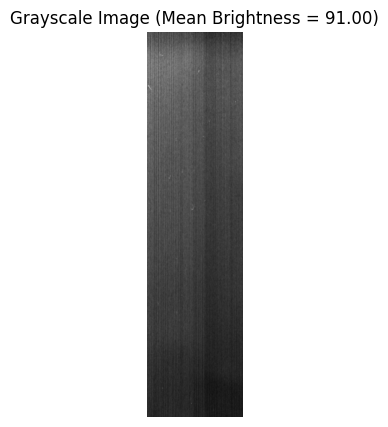

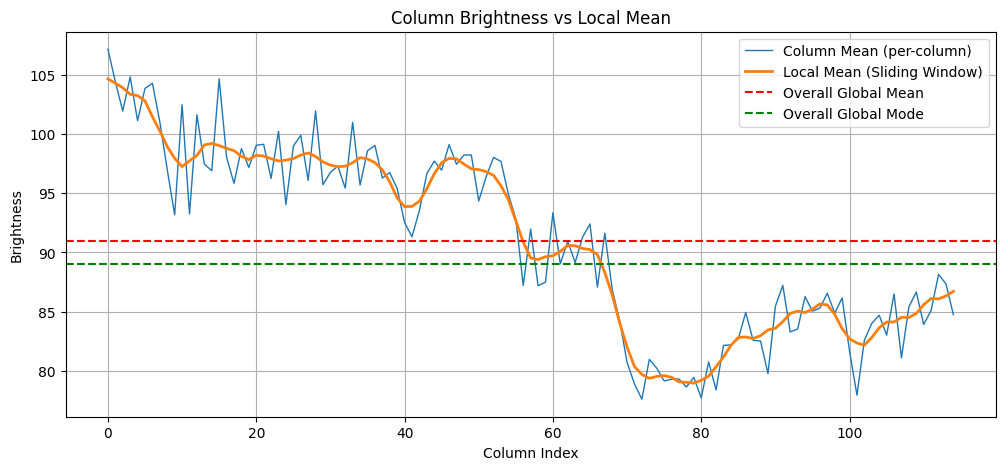


=== Mean-based Defect Region Summary ===
V1: 1 defect region(s)
V2: 1 defect region(s)
V3: 1 defect region(s)

=== MODE-based Defect Region Summary ===
V1: 2 defect region(s)
V2: 2 defect region(s)
V3: 1 defect region(s)




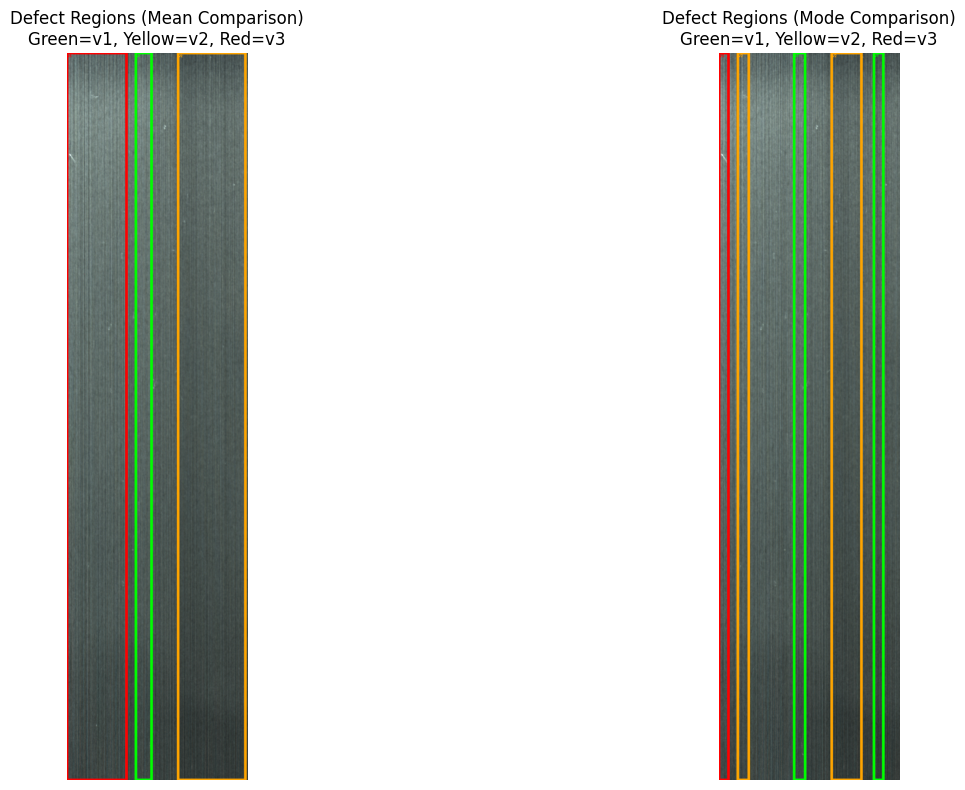

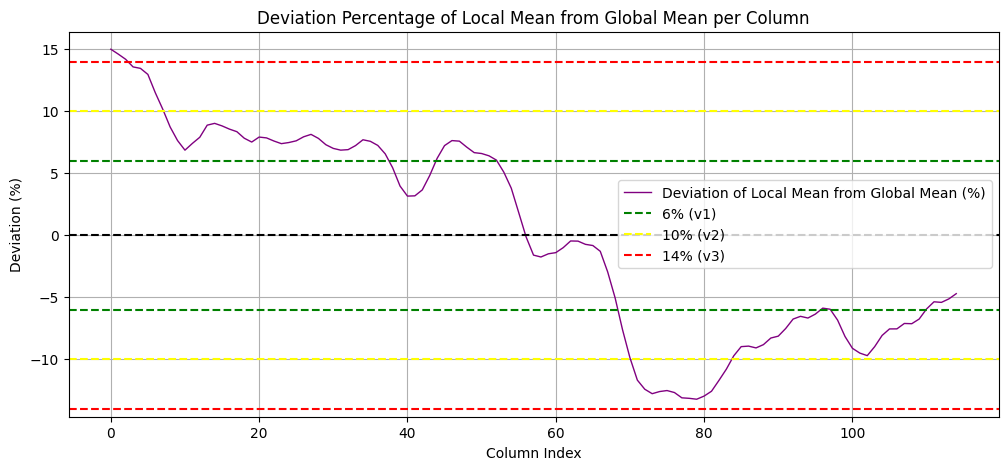

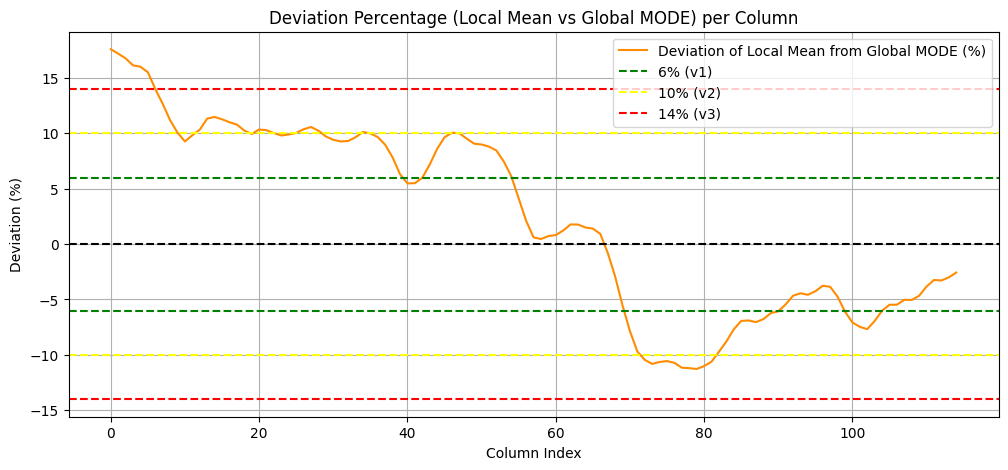

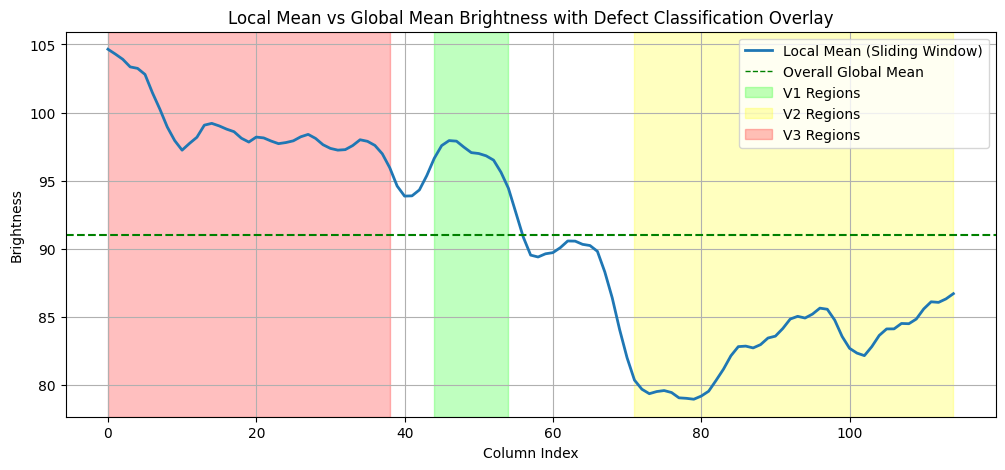

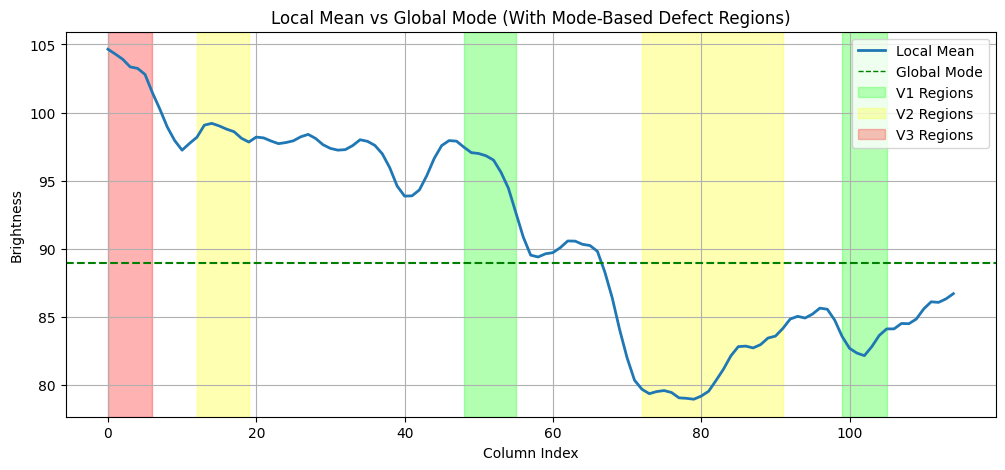

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter

# --- Load and preprocess image ---
img_path = r"Evenness/Testing/3.png"  
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = gray.shape

# --- Adjustable column width ---
column_width = 10  # Increase this to widen each column before computing mean

# --- Recalculate number of columns based on width ---
num_cols = w // column_width #1600/15=107 column, where each strip is 11cm(i.e., 10 columns = 1mm)
if num_cols <= 0:
    raise ValueError("Column width too large for image width.")

# --- Compute column-wise mean brightness with wider columns ---
column_means = []
for i in range(num_cols):
    start = i * column_width
    end = min((i + 1) * column_width, w)
    block = gray[:, start:end]
    col_mean = np.mean(block)
    column_means.append(col_mean)
column_means = np.array(column_means)

# --- Compute overall mean and mode brightness ---
mean_brightness = float(np.mean(gray))
# compute mode from whole image (flatten)
mode_res = stats.mode(gray.flatten(), keepdims=True)
mode_brightness = float(mode_res.mode[0]) if mode_res.count.size > 0 else 0.0

print(f"Overall Mean Brightness: {mean_brightness:.2f}")
print(f"Overall Mode Brightness: {mode_brightness:.2f}")

# --- Sliding window local statistics (local mean & std per column) ---
window_size = 5  # number of neighboring columns for local stats (odd recommended)
half_w = window_size // 2

local_means = []
local_stds = []
for i in range(num_cols):
    start = max(0, i - half_w)
    end = min(num_cols, i + half_w + 1)
    local_region = column_means[start:end]
    local_means.append(np.mean(local_region))
    local_stds.append(np.std(local_region))
local_means = np.array(local_means)
local_stds = np.array(local_stds)
local_means = savgol_filter(local_means, window_length=5, polyorder=2)
# --- Compute deviation percentage using Local Mean vs Global Mean (per your request) ---
eps = 1e-8
deviation_percent = ((local_means - mean_brightness) / (mean_brightness + eps)) * 100

# --- Classification thresholds ---
v1_threshold = 6
v2_threshold = 10
v3_threshold = 14

v1_exit = 5        # lower exit
v2_exit = 9
v3_exit = 13

colors = {
    'v1': (0, 255, 0),       # Bright Green
    'v2': (0, 165, 255),     # Bright Orange
    'v3': (0, 0, 255)        # Bright Red
}


priority = {'v1': 1, 'v2': 2, 'v3': 3}
mpl_colors = {'v1': (0, 1, 0, 0.25), 'v2': (1, 1, 0, 0.25), 'v3': (1, 0, 0, 0.25)}  # RGBA for plotting regions

# --- Classify columns based on deviation_percent ---
def hysteresis_classify(values):
    classes = []
    state = None

    for d in values:
        ad = abs(d)

        # --- ENTER RULES ---
        if ad >= v3_threshold:
            state = "v3"
        elif ad >= v2_threshold:
            if state != "v3":
                state = "v2"
        elif ad >= v1_threshold:
            if state not in ["v2", "v3"]:
                state = "v1"
        else:
            # --- EXIT RULES (hysteresis) ---
            if state == "v3" and ad < v3_exit:
                state = None
            elif state == "v2" and ad < v2_exit:
                state = None
            elif state == "v1" and ad < v1_exit:
                state = None

        classes.append(state)

    return classes

column_classes = hysteresis_classify(deviation_percent)

# --- Merge adjacent columns of the same class into regions ---
regions = []
start = None
current_class = None

for i in range(num_cols):
    c = column_classes[i]
    if c != current_class:
        if current_class is not None:
            regions.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
# close the last region
if current_class is not None:
    regions.append((start, num_cols - 1, current_class))

# --- Apply minimum region length condition (number of consecutive columns) ---
min_cols_for_defect = 6
filtered_regions = [
    (start, end, cls)
    for start, end, cls in regions
    if (end - start + 1) >= min_cols_for_defect
]

# --- Resolve overlapping boxes: keep only highest-priority class ---
final_classes = [None] * num_cols
for start, end, cls in filtered_regions:
    for i in range(start, end + 1):
        if final_classes[i] is None or priority[cls] > priority.get(final_classes[i], 0):
            final_classes[i] = cls

# --- Rebuild final regions after overlap resolution ---
final_regions = []
start = None
current_class = None
for i in range(num_cols):
    c = final_classes[i]
    if c != current_class:
        if current_class is not None:
            final_regions.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
if current_class is not None:
    final_regions.append((start, num_cols - 1, current_class))

#merge adjacent bounding box if their distance is less than min_cols_for_defect
merged_regions = []
i = 0

while i < len(final_regions):
    start1, end1, cls1 = final_regions[i]
    width1 = end1 - start1 + 1

    # Look ahead for merging candidate
    j = i + 1
    while j < len(final_regions):
        start2, end2, cls2 = final_regions[j]
        width2 = end2 - start2 + 1

        # distance between current region and next region
        gap = start2 - end1 - 1

        if gap < min_cols_for_defect:
            chosen_class = cls1 if width1 >= width2 else cls2

            # Merge the two regions
            end1 = end2
            cls1 = chosen_class
            width1 = end1 - start1 + 1

            j += 1
        else:
            break

    merged_regions.append((start1, end1, cls1))
    i = j

# Replace old final_regions
final_regions = merged_regions

# --- Draw final bounding boxes on a copy of the original image ---
output_img = img.copy()
class_counts = {'v1': 0, 'v2': 0, 'v3': 0}

for start, end, cls in final_regions:
    color = colors[cls]
    x1 = start * column_width
    x2 = min((end + 1) * column_width, w - 1)
    cv2.rectangle(output_img, (x1, 0), (x2, h - 1), color, 15)
    class_counts[cls] += 1
    cv2.putText(output_img, cls.upper(), (x1 + 5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# --- Plot 1: Grayscale image ---
plt.figure(figsize=(10, 5))
plt.imshow(gray, cmap='gray')
plt.title(f"Grayscale Image (Mean Brightness = {mean_brightness:.2f})")
plt.axis("off")
plt.show()

# --- Plot 2: Column brightness with Local Mean and Global Mean ---
plt.figure(figsize=(12, 5))
plt.plot(column_means, label='Column Mean (per-column)', linewidth=1)
plt.plot(local_means, label='Local Mean (Sliding Window)', linewidth=2)
plt.axhline(y=mean_brightness, color='red', linestyle='--', label='Overall Global Mean')
plt.axhline(y=mode_brightness, color='green', linestyle='--', label='Overall Global Mode')
plt.title("Column Brightness vs Local Mean")
plt.xlabel("Column Index")
plt.ylabel("Brightness")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
#      PIPELINE → USING GLOBAL MODE AS COMPARATOR
# ============================================================

# --- Compute deviation percentage using Local Mean vs Global MODE ---
deviation_percent_mode = ((local_means - mode_brightness) / (mode_brightness + eps)) * 100

# --- Classify columns based on deviation from MODE ---
column_classes_mode = [classify(dev) for dev in deviation_percent_mode]

# --- Merge adjacent columns of same class ---
regions_mode = []
start = None
current_class = None
for i in range(num_cols):
    c = column_classes_mode[i]
    if c != current_class:
        if current_class is not None:
            regions_mode.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
if current_class is not None:
    regions_mode.append((start, num_cols - 1, current_class))

# --- Apply minimum consecutive column rule ---
filtered_regions_mode = [
    (start, end, cls)
    for start, end, cls in regions_mode
    if (end - start + 1) >= min_cols_for_defect
]

# --- Resolve overlap using priority ---
final_classes_mode = [None] * num_cols
for start, end, cls in filtered_regions_mode:
    for i in range(start, end + 1):
        if final_classes_mode[i] is None or priority[cls] > priority.get(final_classes_mode[i], 0):
            final_classes_mode[i] = cls

# --- Rebuild merged regions ---
final_regions_mode = []
start = None
current_class = None
for i in range(num_cols):
    c = final_classes_mode[i]
    if c != current_class:
        if current_class is not None:
            final_regions_mode.append((start, i - 1, current_class))
        start = i if c is not None else None
        current_class = c
if current_class is not None:
    final_regions_mode.append((start, num_cols - 1, current_class))

merged_regions_mode = []
i = 0

while i < len(final_regions_mode):
    start1, end1, cls1 = final_regions_mode[i]
    width1 = end1 - start1 + 1

    j = i + 1
    while j < len(final_regions_mode):
        start2, end2, cls2 = final_regions_mode[j]
        width2 = end2 - start2 + 1

        gap = start2 - end1 - 1

        if gap < min_cols_for_defect:
            chosen_class = cls1 if width1 >= width2 else cls2
            end1 = end2
            cls1 = chosen_class
            width1 = end1 - start1 + 1
            j += 1
        else:
            break

    merged_regions_mode.append((start1, end1, cls1))
    i = j

final_regions_mode = merged_regions_mode

# --- Draw bounding boxes for MODE-based detection ---
output_img_mode = img.copy()
class_counts_mode = {'v1': 0, 'v2': 0, 'v3': 0}

for start, end, cls in final_regions_mode:
    color = colors[cls]
    x1 = start * column_width
    x2 = min((end + 1) * column_width, w - 1)
    cv2.rectangle(output_img_mode, (x1, 0), (x2, h - 1), color, 15)
    class_counts_mode[cls] += 1
    cv2.putText(output_img_mode, cls.upper(), (x1 + 5, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# --- Print defect statistics ---
print("\n=== Mean-based Defect Region Summary ===")
for cls, count in class_counts.items():
    print(f"{cls.upper()}: {count} defect region(s)")

# --- Print statistics ---
print("\n=== MODE-based Defect Region Summary ===")
for cls, count in class_counts_mode.items():
    print(f"{cls.upper()}: {count} defect region(s)")
print("\n")
# --- Classified bounding boxes (output image Mean) ---
output_path = "detected_defects_MEAN.jpg"
cv2.imwrite(output_path, output_img)

# --- Classified bounding boxes (output image Mode) ---
output_mode_path = "detected_defects_MODE.jpg"
cv2.imwrite(output_mode_path, output_img_mode)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Defect Regions (Mean Comparison)\nGreen=v1, Yellow=v2, Red=v3")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_img_mode, cv2.COLOR_BGR2RGB))
plt.title("Defect Regions (Mode Comparison)\nGreen=v1, Yellow=v2, Red=v3")
plt.axis("off")

plt.tight_layout()
plt.show()


# --- Plot: Deviation percentage graph (Local Mean vs Global Mean) ---
plt.figure(figsize=(12, 5))
plt.plot(deviation_percent, label='Deviation of Local Mean from Global Mean (%)', color='purple', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=v1_threshold, color='green', linestyle='--', label=f'{v1_threshold}% (v1)')
plt.axhline(y=-v1_threshold, color='green', linestyle='--')
plt.axhline(y=v2_threshold, color='yellow', linestyle='--', label=f'{v2_threshold}% (v2)')
plt.axhline(y=-v2_threshold, color='yellow', linestyle='--')
plt.axhline(y=v3_threshold, color='red', linestyle='--', label=f'{v3_threshold}% (v3)')
plt.axhline(y=-v3_threshold, color='red', linestyle='--')
plt.title("Deviation Percentage of Local Mean from Global Mean per Column")
plt.xlabel("Column Index")
plt.ylabel("Deviation (%)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot: Deviation Percentage (Local Mean vs Global MODE) ---
plt.figure(figsize=(12, 5))
plt.plot(deviation_percent_mode, label='Deviation of Local Mean from Global MODE (%)',
         color='darkorange', linewidth=1.5)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=v1_threshold, color='green', linestyle='--', label=f'{v1_threshold}% (v1)')
plt.axhline(y=-v1_threshold, color='green', linestyle='--')
plt.axhline(y=v2_threshold, color='yellow', linestyle='--', label=f'{v2_threshold}% (v2)')
plt.axhline(y=-v2_threshold, color='yellow', linestyle='--')
plt.axhline(y=v3_threshold, color='red', linestyle='--', label=f'{v3_threshold}% (v3)')
plt.axhline(y=-v3_threshold, color='red', linestyle='--')

plt.title("Deviation Percentage (Local Mean vs Global MODE) per Column")
plt.xlabel("Column Index")
plt.ylabel("Deviation (%)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot: Local Mean vs Global Mean brightness with defect classification overlay ---
plt.figure(figsize=(12, 5))
plt.plot(local_means, label='Local Mean (Sliding Window)', linewidth=2)
plt.axhline(y=mean_brightness, color='green', linestyle='--', label='Overall Global Mean')

for start, end, cls in final_regions:
    x1 = start
    x2 = end + 1
    plt.axvspan(x1, x2, color=mpl_colors.get(cls, (0,0,0,0.15)), label=f"{cls.upper()} region" if False else None)

handles = [
    plt.Line2D([0], [0], color='C0', lw=2, label='Local Mean (Sliding Window)'),
    plt.Line2D([0], [0], color='green', lw=1, linestyle='--', label='Overall Global Mean'),
    plt.Rectangle((0,0),1,1, color=mpl_colors['v1'], label='V1 Regions'),
    plt.Rectangle((0,0),1,1, color=mpl_colors['v2'], label='V2 Regions'),
    plt.Rectangle((0,0),1,1, color=mpl_colors['v3'], label='V3 Regions'),
]
plt.title("Local Mean vs Global Mean Brightness with Defect Classification Overlay")
plt.xlabel("Column Index")
plt.ylabel("Brightness")
plt.legend(handles=handles)
plt.grid(True)
plt.show()

# --- Plot: Local Mean vs Global Mode ---
plt.figure(figsize=(12, 5))
plt.plot(local_means, label='Local Mean (Sliding Window)', linewidth=2)
plt.axhline(y=mode_brightness, color='green', linestyle='--', label='Global Mode')

for start, end, cls in final_regions_mode:
    plt.axvspan(start, end + 1, color=mpl_colors[cls], alpha=0.3)

handles = [
    plt.Line2D([0], [0], color='C0', lw=2, label='Local Mean'),
    plt.Line2D([0], [0], color='green', lw=1, linestyle='--', label='Global Mode'),
    plt.Rectangle((0, 0), 1, 1, color=mpl_colors['v1'], label='V1 Regions'),
    plt.Rectangle((0, 0), 1, 1, color=mpl_colors['v2'], label='V2 Regions'),
    plt.Rectangle((0, 0), 1, 1, color=mpl_colors['v3'], label='V3 Regions'),
]
plt.title("Local Mean vs Global Mode (With Mode-Based Defect Regions)")
plt.xlabel("Column Index")
plt.ylabel("Brightness")
plt.legend(handles=handles)
plt.grid(True)
plt.show()

## Mass Processing

In [48]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from scipy import stats

# ============================
# USER CONFIG
# ============================
folder_path = r"Evenness/Testing"   # <-- CHANGE ME: folder with images
output_csv = "defect_summary.csv"
output_image_dir = "output_images"

# analysis parameters (same as your final code)
column_width = 15
window_size = 5
v1_threshold = 5
v2_threshold = 8
v3_threshold = 11
min_cols_for_defect = 8

# create output dir
os.makedirs(output_image_dir, exist_ok=True)

# colors for drawing (BGR)
colors = {
    'v1': (0, 255, 0),       # Bright Green
    'v2': (0, 165, 255),     # Bright Orange
    'v3': (0, 0, 255)        # Bright Red
}
priority = {'v1': 1, 'v2': 2, 'v3': 3}


def classify(dev):
    """Classify by deviation percentage into v1 / v2 / v3."""
    abs_dev = abs(dev)
    if abs_dev >= v3_threshold:
        return 'v3'
    elif abs_dev >= v2_threshold:
        return 'v2'
    elif abs_dev >= v1_threshold:
        return 'v1'
    else:
        return None


def compute_regions_from_comparator(local_means, comparator_value, num_cols, min_cols):
    """
    Given local_means and a comparator (global mean or mode),
    compute final merged regions + class counts, following your logic.
    Returns (final_regions, class_counts).
    """
    eps = 1e-8
    deviation_percent = ((local_means - comparator_value) / (comparator_value + eps)) * 100

    # classify columns
    column_classes = [classify(dev) for dev in deviation_percent]

    # merge adjacent same-class into regions
    regions = []
    start = None
    current_class = None
    for i in range(num_cols):
        c = column_classes[i]
        if c != current_class:
            if current_class is not None:
                regions.append((start, i - 1, current_class))
            start = i if c is not None else None
            current_class = c
    if current_class is not None:
        regions.append((start, num_cols - 1, current_class))

    # keep regions with length >= min_cols
    filtered_regions = [
        (start, end, cls)
        for start, end, cls in regions
        if (end - start + 1) >= min_cols
    ]

    # overlap resolution by priority
    final_classes = [None] * num_cols
    for start, end, cls in filtered_regions:
        for i in range(start, end + 1):
            if final_classes[i] is None or priority[cls] > priority.get(final_classes[i], 0):
                final_classes[i] = cls

    # rebuild regions from final_classes
    final_regions = []
    start = None
    current_class = None
    for i in range(num_cols):
        c = final_classes[i]
        if c != current_class:
            if current_class is not None:
                final_regions.append((start, i - 1, current_class))
            start = i if c is not None else None
            current_class = c
    if current_class is not None:
        final_regions.append((start, num_cols - 1, current_class))

    # merge nearby boxes if gap < min_cols, keep wider class
    merged_regions = []
    i = 0
    while i < len(final_regions):
        start1, end1, cls1 = final_regions[i]
        width1 = end1 - start1 + 1

        j = i + 1
        while j < len(final_regions):
            start2, end2, cls2 = final_regions[j]
            width2 = end2 - start2 + 1
            gap = start2 - end1 - 1

            if gap < min_cols:
                # choose class with larger width
                chosen_class = cls1 if width1 >= width2 else cls2
                end1 = end2
                cls1 = chosen_class
                width1 = end1 - start1 + 1
                j += 1
            else:
                break

        merged_regions.append((start1, end1, cls1))
        i = j

    # count classes
    class_counts = {'v1': 0, 'v2': 0, 'v3': 0}
    for _, _, cls in merged_regions:
        if cls is not None:
            class_counts[cls] += 1

    return merged_regions, class_counts, deviation_percent


def process_image(img_path):
    """Run the full pipeline on a single image and return summary + save images."""
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {img_path}, skipping.")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    # column means
    num_cols = w // column_width
    if num_cols <= 0:
        print(f"Image {img_name}: column_width too large, skipping.")
        return None

    column_means = []
    for i in range(num_cols):
        start = i * column_width
        end = min((i + 1) * column_width, w)
        block = gray[:, start:end]
        column_means.append(np.mean(block))
    column_means = np.array(column_means)

    # global mean & mode
    mean_brightness = float(np.mean(gray))
    mode_res = stats.mode(gray.flatten(), keepdims=True)
    mode_brightness = float(mode_res.mode[0]) if mode_res.count.size > 0 else 0.0

    # local means
    half_w = window_size // 2
    local_means = []
    for i in range(num_cols):
        s = max(0, i - half_w)
        e = min(num_cols, i + half_w + 1)
        local_means.append(np.mean(column_means[s:e]))
    local_means = np.array(local_means)

    # ===== MEAN COMPARATOR =====
    final_regions_mean, class_counts_mean, dev_mean = compute_regions_from_comparator(
        local_means, mean_brightness, num_cols, min_cols_for_defect
    )

    # draw boxes for MEAN comparator
    output_img_mean = img.copy()
    for start, end, cls in final_regions_mean:
        if cls is None:
            continue
        color = colors[cls]
        x1 = start * column_width
        x2 = min((end + 1) * column_width, w - 1)
        cv2.rectangle(output_img_mean, (x1, 0), (x2, h - 1), color, 15)
        cv2.putText(output_img_mean, cls.upper(), (x1 + 5, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # save MEAN image
    mean_out_path = os.path.join(
        output_image_dir,
        f"{os.path.splitext(img_name)[0]}_MEAN.jpg"
    )
    cv2.imwrite(mean_out_path, output_img_mean)

    # ===== MODE COMPARATOR =====
    final_regions_mode, class_counts_mode, dev_mode = compute_regions_from_comparator(
        local_means, mode_brightness, num_cols, min_cols_for_defect
    )

    # draw boxes for MODE comparator
    output_img_mode = img.copy()
    for start, end, cls in final_regions_mode:
        if cls is None:
            continue
        color = colors[cls]
        x1 = start * column_width
        x2 = min((end + 1) * column_width, w - 1)
        cv2.rectangle(output_img_mode, (x1, 0), (x2, h - 1), color, 15)
        cv2.putText(output_img_mode, cls.upper(), (x1 + 5, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # save MODE image
    mode_out_path = os.path.join(
        output_image_dir,
        f"{os.path.splitext(img_name)[0]}_MODE.jpg"
    )
    cv2.imwrite(mode_out_path, output_img_mode)

    # build summary row
    summary = {
        "Image": img_name,
        "Mean_Brightness": mean_brightness,
        "Mode_Brightness": mode_brightness,
        "Mean_v1_Count": class_counts_mean['v1'],
        "Mean_v2_Count": class_counts_mean['v2'],
        "Mean_v3_Count": class_counts_mean['v3'],
        "Mean_Total_Defects": sum(class_counts_mean.values()),
        "Mode_v1_Count": class_counts_mode['v1'],
        "Mode_v2_Count": class_counts_mode['v2'],
        "Mode_v3_Count": class_counts_mode['v3'],
        "Mode_Total_Defects": sum(class_counts_mode.values()),
    }

    print(f"Processed {img_name}: MEAN defects={summary['Mean_Total_Defects']}, "
          f"MODE defects={summary['Mode_Total_Defects']}")
    return summary


# ============================
# MAIN LOOP OVER IMAGES
# ============================
image_paths = sorted(
    p for p in glob.glob(os.path.join(folder_path, "*"))
    if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
)

if not image_paths:
    raise RuntimeError(f"No image files found in {folder_path}")

# process at most 10 images
image_paths = image_paths[:10]

rows = []
for path in image_paths:
    row = process_image(path)
    if row is not None:
        rows.append(row)

# save CSV
df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False)
print(f"\nSaved defect summary for {len(rows)} image(s) to {output_csv}")
print(f"Annotated images saved to: {output_image_dir}")


Processed 1.png: MEAN defects=2, MODE defects=2
Processed 10.png: MEAN defects=0, MODE defects=0
Processed 2.png: MEAN defects=0, MODE defects=1
Processed 3.png: MEAN defects=1, MODE defects=1
Processed 4.png: MEAN defects=0, MODE defects=1
Processed 5.png: MEAN defects=1, MODE defects=1
Processed 6.png: MEAN defects=1, MODE defects=0
Processed 7.png: MEAN defects=0, MODE defects=1
Processed 8.png: MEAN defects=2, MODE defects=1
Processed 9.png: MEAN defects=0, MODE defects=2

Saved defect summary for 10 image(s) to defect_summary.csv
Annotated images saved to: output_images


## Mass processing for cleaness and neatness

In [28]:
import os
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from collections import defaultdict
from datetime import datetime

# --------------------------------------------------
# CONFIG
# --------------------------------------------------
MODEL_PATH = "best.pt"                 # YOLO model
OUTPUT_DIR = "batch_output"            # annotated output images
CSV_LOG = "batch_results.csv"          # CSV output file
IMG_EXT = {".jpg", ".jpeg", ".png"}    # allowed formats
os.makedirs(OUTPUT_DIR, exist_ok=True)

# defect category groups
CLEANLINESS_CLASSES = {"minor", "major", "supermajor", "super_major"}
NEATNESS_CLASSES = {"neatness"}

# --------------------------------------------------
# LOAD YOLO MODEL
# --------------------------------------------------
model = YOLO(MODEL_PATH)


def run_batch_yolo(folder_path):
    """
    Run YOLO inference on all images inside a folder
    and save results to CSV.
    """

    if not os.path.exists(folder_path):
        print("❌ Folder does not exist:", folder_path)
        return

    results_list = []

    # ------------------------------------------
    # PROCESS ALL IMAGES
    # ------------------------------------------
    for filename in os.listdir(folder_path):
        ext = os.path.splitext(filename)[1].lower()
        if ext not in IMG_EXT:
            continue  # skip non-images

        img_path = os.path.join(folder_path, filename)
        print(f"🔍 Processing: {filename}")

        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Skipping invalid image: {filename}")
            continue

        # run inference
        results = model(img)
        annotated = results[0].plot()

        # save annotated image
        output_path = os.path.join(OUTPUT_DIR, filename)
        cv2.imwrite(output_path, annotated)

        # defect counting
        defect_counts = defaultdict(int)
        total_defects = 0

        if results[0].boxes:
            class_ids = results[0].boxes.cls.cpu().numpy()
            class_names = results[0].names

            for cid in class_ids:
                cls_name = class_names[int(cid)]
                defect_counts[cls_name] += 1
                total_defects += 1

        # build result row
        cleanliness = {cls: defect_counts.get(cls, 0) for cls in CLEANLINESS_CLASSES}
        neatness = {cls: defect_counts.get(cls, 0) for cls in NEATNESS_CLASSES}

        row = {
            "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "Image_Name": filename,
            **{f"Cleanliness_{k}": cleanliness[k] for k in CLEANLINESS_CLASSES},
            **{f"Neatness_{k}": neatness[k] for k in NEATNESS_CLASSES},
            "Total_Defects": total_defects,
            "Output_Image_Path": output_path
        }

        results_list.append(row)

    # ------------------------------------------
    # SAVE CSV
    # ------------------------------------------
    if results_list:
        df = pd.DataFrame(results_list)
        df.to_csv(CSV_LOG, index=False)
        print("\n✅ CSV saved as:", CSV_LOG)
        print("📁 Output images saved in:", OUTPUT_DIR)
    else:
        print("⚠️ No valid images found in the folder.")


# --------------------------------------------------
# MAIN ENTRY
# --------------------------------------------------
if __name__ == "__main__":
    folder = r"Evenness/Testing"
    run_batch_yolo(folder)


🔍 Processing: 1.png

0: 1280x320 1 major, 77.4ms
Speed: 8.3ms preprocess, 77.4ms inference, 206.8ms postprocess per image at shape (1, 3, 1280, 320)
🔍 Processing: 10.png

0: 1280x352 (no detections), 63.2ms
Speed: 5.6ms preprocess, 63.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 352)
🔍 Processing: 2.png

0: 1280x320 1 minor, 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 1280, 320)
🔍 Processing: 3.png

0: 1280x320 2 minors, 10.7ms
Speed: 4.5ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 320)
🔍 Processing: 4.png

0: 1280x320 (no detections), 14.5ms
Speed: 6.4ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 320)
🔍 Processing: 5.png

0: 1280x320 1 minor, 11.2ms
Speed: 4.8ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 1280, 320)
🔍 Processing: 6.png

0: 1280x352 (no detections), 12.1ms
Speed: 4.9ms preprocess, 12.1ms inference